# Alignment cue performance for MusicLab Copenhegan 

Notebook describing and analysing effectiveness of human tapping synchronisation cue used to align signals between mobile phone recordings in the concert hall and remotely. 

1. Describe the synchronisation cue: why tapping to a beat, why two tempi
2. Describe the identification of cue in motion recordings: crosscorrelation within reliable area, shape of motion model and signal feature. Nice result, not nice result
3. Report reliability of cue: rate of automatically detected, rate of supervised detected, quality of alignment for first second and third tap (based on total), rate of correctly performing task
4. Report resultant precision: Are two cues needed? For local no, except increases chances of capturing one good cue. Reached X precision, between human error, sample rate, and confidence. For remote yes, maybe want more as stream delays may cause discontinuous shifts.
5. Use cue again? Gains of precesion from Y to X local and remote. Maybe use different tempo combo with higher integer ratio

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

Setting up datasets and ploting essentials

In [3]:
# windows machine data path
data_path = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/All'
instIDs = os.listdir(data_path)

In [4]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)
# device times 10 Hs
ts_dt = pd.date_range(Start_time,End_time, freq='20ms')
ts_ts = np.arange(Start_time.timestamp(),End_time.timestamp(), 0.02)*1000
# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')
#[dt_ct[0],dt_ct[-1]]

concert_times = pd.read_csv('C:/Users/finnu/dev/MusicLabCopenhegan_MotionAlignment/timing/concert_events.csv',",") #SV alignment for beeps
concert_times['S_AudioTime'] = 2*np.round(concert_times["TIME"]/2,2) # reset to 50 hz
concert_times['event'] = concert_times["LABEL"]

concert_times['CTime'] = concert_times['S_AudioTime']-concert_times.loc[38,'S_AudioTime'] # zero on onset of first synch cue
concert_times['StimTime'] = pd.to_timedelta(concert_times['CTime'],unit = 's')
concert_times['ConcertdTime'] = concert_times['StimTime'] + pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
concert_times['time_concert'] = concert_times['CTime']
concert_times=concert_times.set_index('ConcertdTime', drop=True)
concert_times

,TIME,LABEL,S_AudioTime,event,CTime,StimTime,time_concert
ConcertdTime,,,,,,,
2021-10-26 17:36:34.760,946.00,Claps on,946.00,Claps on,-691.24,-1 days +23:48:28.760000,-691.24
2021-10-26 17:36:51.880,963.13,Claps off,963.12,Claps off,-674.12,-1 days +23:48:45.880000,-674.12
2021-10-26 17:36:52.880,964.11,Speach Danish,964.12,Speach Danish,-673.12,-1 days +23:48:46.880000,-673.12
2021-10-26 17:37:09.880,981.12,Speach English,981.12,Speach English,-656.12,-1 days +23:49:03.880000,-656.12
2021-10-26 17:37:20.400,991.64,Speach Danish,991.64,Speach Danish,-645.60,-1 days +23:49:14.400000,-645.60
...,...,...,...,...,...,...,...
2021-10-26 20:02:08.240,9679.49,Claps on,9679.48,Claps on,8042.24,0 days 02:14:02.240000,8042.24
2021-10-26 20:02:30.040,9701.27,Claps iso,9701.28,Claps iso,8064.04,0 days 02:14:24.040000,8064.04
2021-10-26 20:03:55.280,9786.51,Claps off,9786.52,Claps off,8149.28,0 days 02:15:49.280000,8149.28


In [9]:
def appfileconcat(folder,file_suffix):
    # function to concatonate the one minute mobile sensor time series in files generated by MusicLab (0.0.17)
    #   files must be within a single folder, share a common suffix, that alphabetised file names ensures 
    #   chronological order (i.e. these files have submission IDs prepended), be immidiately readable by pandas read_csv
    #   (top row: column names, following rows only samples) and include a column titled "time" with device-consistent 
    #   timestampe values that continue accross files and in the same units as gap_t
    # This function uses libraries: os, pandas as pd, and local definition nannotime
    #
    # This function does not add nans in gaps, so interpolators beware. Pass any extracted file through gap_nans before resampling.
    #
    # Inputs:
    #   folder: string, relative path to the folder with the files to concatonate
    #   file_suffix: string, ending of file names for files to concatenate. ex: '.csv', 'deviceMotion.csv'
    #   inst_data: pandas dataframe containing all the samples across files, with inserted np.nan, in chronological order

    inst_data = pd.DataFrame()

    filenames = os.listdir(folder)
    filenames.sort() # files are processed in order set by sample index
    f_Count = 0
    # print(len(filenames))
    for fn in filenames:
        if fn.endswith(file_suffix):
        # if not begining, check for overlap
            if len(inst_data)>0:
                last_ts = inst_data.timestamp.max()
                tr = pd.read_csv(folder + '/' + fn)
                if tr.timestamp.min()<inst_data.timestamp.max():
                    tr = tr.loc[tr.timestamp>inst_data.timestamp.max(),:]
                    inst_data = pd.concat([inst_data,tr],ignore_index=True)
                else:
                    # add the files data to inst_data    
                    inst_data = pd.concat([inst_data,tr],ignore_index=True)
            else: 
                inst_data = pd.read_csv(folder + '/' + fn)
            f_Count +=1
    print( folder + ', ' + str(f_Count)) 
            
    cols = inst_data.columns
#     if 'time' in cols:
#         inst_data = inst_data.sort_values('time',ignore_index=True)
#         print('Time sorted')
#     else:
    inst_data = inst_data.sort_values('timestamp',ignore_index=True)
#         print('Timestamp sorted')
    # deal with the instances where time is not a monotonic sequence ??>?>?>?>
    if 'time' in inst_data.columns:
        if inst_data['time'].diff().min()<0:
            # replace time with floats 
            inst_data['time'] = inst_data['timestamp'] - inst_data.loc[0,'timestamp'] + inst_data.loc[0,'time']
        
    return inst_data

# note: these functions require any datetime feilds to be explicitely in pandas datatime formate.
# See examples of how to prep datetime columns in the usage examples below.

def nannotime(row,shift,dshift):
    # function to generate a row of nans with caveats for time fields, which are shifted by a designated ammount 
    r = row.copy()
    cols = r.index
    for c in cols:
        if not c.startswith('time'):
            if not c.startswith('datetime'):
                r[c] = np.nan
            if c.startswith('datetime'):
                r[c] = r[c] + dshift  
        if c.startswith('time'):
            r[c] = r[c] + shift     
    return r

def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    
    data = data.append(nannotime(data.iloc[-1,:],deltat,dtdeltat),ignore_index=True)
    
    dt = data[time_col].diff()
    a = list(dt[dt>gap_t].index)
    a.sort(reverse=True)
    for gapi in a:
        data = data.append(nannotime(data.iloc[gapi-1,:],deltat,dtdeltat))
        data = data.append(nannotime(data.iloc[gapi,:],-deltat,dtdeltat))

    data = data.append(nannotime(data.iloc[0,:],-1,dtdeltat)).sort_values(time_col,ignore_index=True)
    return data

# Example sensor readings

One participant's motion recording, sample

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/1a9a903b-9524-f8c2-a943-81a108880e46, 142


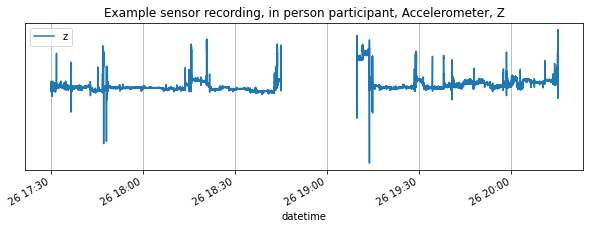

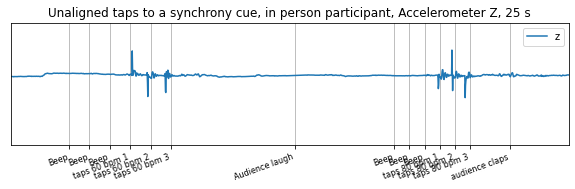

In [5]:
instid = "1a9a903b-9524-f8c2-a943-81a108880e46"#"31f4e1a5-be17-3a37-ee86-1e215ffcb996"

folder = data_path + '/' + instid
file_suffix = 'deviceMotion.csv'

# this function concatonates the dozens or hundreds of minute long recordings into single dataframe. It does this without 
inst_d = appfileconcat(folder,file_suffix) 
inst_d = gap_nans(inst_d,1000)
inst_d['datetime']=(pd.to_datetime(inst_d['timestamp'],unit='ms'))

# testing the 
inst_d.plot.line(x='datetime',y='z',figsize=[10,3])
plt.grid()
plt.title('Example sensor recording, in person participant, Accelerometer, Z')
plt.yticks([])
plt.savefig('SampleACCZ.png',dpi=300)
plt.show()
inst_d.plot.line(x='datetime',y='z',figsize=[10,2.5])
plt.yticks([])
plt.title('Unaligned taps to a synchrony cue, in person participant, Accelerometer Z, 25 s')
plt.xticks(concert_times.index,concert_times.event, rotation='20',fontsize=8)
plt.xlabel('')
plt.xlim([inst_d['datetime'].iloc[283400],inst_d['datetime'].iloc[285000]])
plt.grid()
plt.savefig('SampleACCZ_secondtaps.png',dpi=300)
plt.show()


The taps caught here in device time put them close but seemingly in advance of the beeps they were instructed to tap with. While some negative asynchrony is expected in non-musicians tapping to an isochronous beat, the factor more prominent here would be a late first tap followed by better aligned subsequent gestures. To find the device time offset from concert time, we cross correlate a feature of the accelerometer data with a template time series.

These sensor readings were only roughly isochronous and had numerous gaps over the course of the concert, so they were resampled at 50 Hz (a bit below to mode sample rate) and the three dimensional recordings were summarised by the norm of the first order difference to aggregate motion in all directions. This was then normalised on the feature median and thresholded to give each tap similar weighting in the cross correlation.

# Tapping template and offset evaluation

In [6]:
# first interval with synch cues
t_range1 = [ts_dt[53000],ts_dt[62000]]
aud_df = pd.DataFrame(index = ts_dt[:-1])
sec_df = aud_df.loc[t_range1[0]:t_range1[1],:]

In [7]:
time_data_folder = 'C:/Users/finnu/dev/MusicLabCopenhegan_MotionAlignment/timing/'

In [8]:
# draw up synchonised cue files
cues1=pd.read_csv(time_data_folder + 'synch1_cues.csv',index_col=0)
# cues1['time'] = 

cues1['time_concert'] = np.arange(0,180.02, 0.02)*1000 + -26000.0
cues1.index = pd.to_datetime(cues1.index)
cues2=pd.read_csv(time_data_folder + 'synch2_cues.csv',index_col=0)
cues2.index = pd.to_datetime(cues2.index)
cues2['time_concert'] = (np.arange(0,160.02, 0.02))*1000 -34280.0 + 5188280.0

cue_type = 'spointless'

In [9]:
aud_df = pd.DataFrame(index = ts_ts)
gap_t = 1000
dev_n = 0

devFile = instid #devices[12]
# print(devFile)
# data = pd.read_csv(folder + '/' + devFile)
# data['datetime'] = (pd.to_datetime(data['timestamp'],unit='ms'))
# datas = gap_nans(data,gap_t)
# datas['datetime'] = (pd.to_datetime(datas['timestamp'],unit='ms'))

datas = inst_d

resampled = pd.DataFrame(index = ts_dt[:-1])
cols = datas.columns
for col in cols[1:]:
    f = interpolate.interp1d(datas['timestamp'], datas[col],fill_value='extrapolate')
    resampled[col] = f(ts_ts)

b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
if np.nanmedian(b)>0:
    aud_df[dev_n] = b/np.nanmedian(b)
else:
    aud_df[dev_n] = b/np.nanmean(b)

aud_df.index = ts_dt[:-1]

In [10]:
# pull out the section with the synchronisation cues

# first interval with synch cues
t_range1 = [ts_dt[53000],ts_dt[62000]]
sec1_df = aud_df.loc[t_range1[0]:t_range1[1],:]
# second interval with synch cues
t_range2 = [ts_dt[312000],ts_dt[320000]]
sec2_df = aud_df.loc[t_range2[0]:t_range2[1],:]

sampleshift = cues1.index.to_series().diff().median()
sampleshift_s = sampleshift.total_seconds()
cue_type =  'spointless'

length1 = np.min([len(sec1_df),len(cues1)])
length2 = np.min([len(sec2_df),len(cues2)])

devs = sec1_df.columns # list of signals to consider
#synch_offs = pd.DataFrame(index = devs, columns = ["s1_corr0","s1_corr_offset","s1_offset","s2_corr0","s2_corr_offset","s2_offset","devID"])

['0', 'spointless', 0.2705117668288954, 6, 0.12, 4001, 80.02]


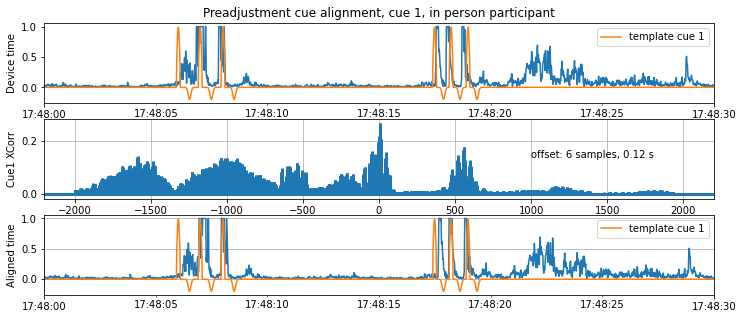

['0', 'spointless', 0.400492977678065, 5, 0.1, 4001, 80.02]


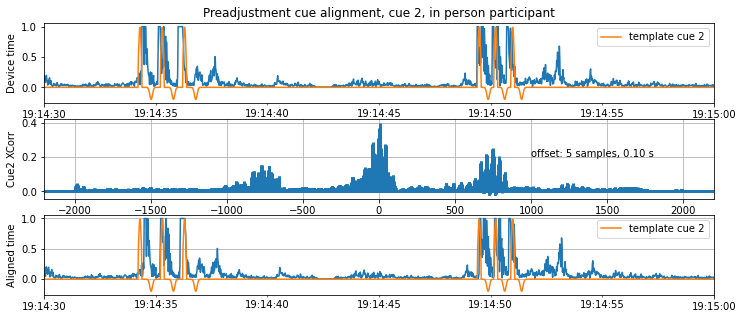

[6, 5]


In [11]:
shifts = []    

# prep signal for synch 1
signal =sec1_df[dev_n].copy()
signal[signal.isna()] = 0
M = signal.quantile(0.995)
signal = signal/M
signal[signal>1] = 1

if signal.diff().abs().sum()<0.1: # signal is flat
    shifts.append(np.nan)
else: 
    # starting alignment between signal and cue
    fig = plt.figure(figsize=(12,5))
    ax1 = plt.subplot(311)
    signal.plot(ax=ax1)
    cues1.plot.line(y=cue_type,ax=ax1,label='template cue 1')
    plt.xlim([cues1.index[1000],cues1.index[2500]])
    plt.ylabel('Device time')
    plt.title('Preadjustment cue alignment, cue 1, in person participant')
    
    ax2 = plt.subplot(312)
    CCC = ax2.xcorr(cues1[cue_type].iloc[:length1], signal.iloc[:length1], usevlines=True, maxlags=np.min([length1-1,2000]), normed=True, lw=3)
    ax2.grid(True)
    shifts.append(CCC[0][np.argmax(CCC[1])])
    print([str(dev_n),cue_type, np.amax(CCC[1]),CCC[0][np.argmax(CCC[1])], (sampleshift_s*CCC[0][np.argmax(CCC[1])]), len(CCC[0]),len(CCC[0])*sampleshift_s]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
    plt.ylabel('Cue1 XCorr')
    signal.index = signal.index + pd.Timedelta(sampleshift_s*CCC[0][np.argmax(CCC[1])],'S')
    plt.text(1000,np.amax(CCC[1])/2,'offset: %d samples, %.2f s' % (CCC[0][np.argmax(CCC[1])],(sampleshift_s*CCC[0][np.argmax(CCC[1])])))
    ax1 = plt.subplot(313)
    signal.plot(ax=ax1)
    cues1.plot.line(y=cue_type,ax=ax1,label='template cue 1')
    plt.xlim([cues1.index[1000],cues1.index[2500]])
    ax1.grid(True)
    plt.ylabel('Aligned time')
    plt.savefig('Sample_cue1_alignment.png',dpi=300)
    plt.show()
    #sigs[c] = signal
    CCC1 = CCC
# prep signal for synch 1
signal =sec2_df[dev_n].copy()
signal[signal.isna()] = 0
M = signal.quantile(0.995)
signal = signal/M
signal[signal>1] = 1

if signal.diff().abs().sum()<0.1: # signal is flat
    shifts.append(np.nan)
else: 
    # starting alignment between signal and cue
    fig = plt.figure(figsize=(12,5))
    ax1 = plt.subplot(311)
    signal.plot(ax=ax1)
    cues2.plot.line(y=cue_type,ax=ax1,label='template cue 2')
    plt.xlim([cues2.index[1500],cues2.index[3000]])
    plt.title('Preadjustment cue alignment, cue 2, in person participant')
    plt.ylabel('Device time')

    ax2 = plt.subplot(312)
    CCC = ax2.xcorr(cues2[cue_type].iloc[:length2], signal.iloc[:length2], usevlines=True, maxlags=np.min([length2-1,2000]), normed=True, lw=3)
    ax2.grid(True)
    shifts.append(CCC[0][np.argmax(CCC[1])])
    plt.ylabel('Cue2 XCorr')
    #xc = np.correlate(signal.iloc[:length],cues[C2].iloc[:length], "full")
    print([str(dev_n),cue_type, np.amax(CCC[1]),CCC[0][np.argmax(CCC[1])], (sampleshift_s*CCC[0][np.argmax(CCC[1])]), len(CCC[0]),len(CCC[0])*sampleshift_s]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
    plt.text(1000,np.amax(CCC[1])/2,'offset: %d samples, %.2f s' % (CCC[0][np.argmax(CCC[1])],(sampleshift_s*CCC[0][np.argmax(CCC[1])])))
   
    signal.index = signal.index + pd.Timedelta(sampleshift_s*CCC[0][np.argmax(CCC[1])],'S')

    ax1 = plt.subplot(313)
    signal.plot(ax=ax1)
    cues2.plot.line(y=cue_type,ax=ax1,label='template cue 2')
    plt.xlim([cues2.index[1500],cues2.index[3000]])
    ax1.grid(True)
    plt.ylabel('Aligned time')
    plt.savefig('Sample_cue2_alignment.png',dpi=300)
    plt.show()
    #sigs[c] = signal
    CCC2 = CCC
    
print(shifts)

Now an example from a remote participant

In [12]:
data_path = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote'
instIDs = os.listdir(data_path)


In [53]:
instid = "06fad321-8a49-062e-1e84-26704be216b8"#"31f4e1a5-be17-3a37-ee86-1e215ffcb996"
#instid = '3bb45cec-548d-4639-2fd8-443d10744bf8'
folder = data_path + '/' + instid
file_suffix = 'deviceMotion.csv'

# this function concatonates the dozens or hundreds of minute long recordings into single dataframe. It does this without 
inst_d = appfileconcat(folder,file_suffix) 
inst_d = gap_nans(inst_d,1000)
inst_d['datetime']=(pd.to_datetime(inst_d['timestamp'],unit='ms'))

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/06fad321-8a49-062e-1e84-26704be216b8, 242


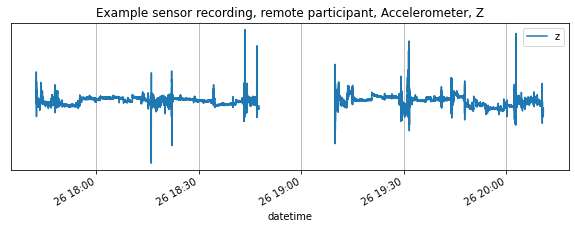

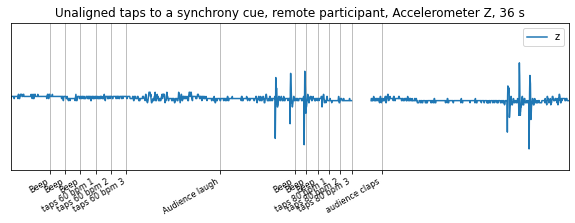

In [54]:

# testing the 
inst_d.plot.line(x='datetime',y='z',figsize=[10,3])
plt.grid()
plt.title('Example sensor recording, remote participant, Accelerometer, Z')
plt.yticks([])
plt.savefig('SampleACCZ_remote.png',dpi=300)
plt.show()
inst_d.plot.line(x='datetime',y='z',figsize=[10,3])
plt.yticks([])
plt.ylim([3,10])
plt.title('Unaligned taps to a synchrony cue, remote participant, Accelerometer Z, 36 s')
plt.xticks(concert_times.index,concert_times.event, rotation='30',fontsize=8)
plt.xlabel('')
plt.xlim([inst_d['datetime'].iloc[240400],inst_d['datetime'].iloc[242500]])
plt.grid()
plt.savefig('SampleACCZ_secondtaps_Remote.png',dpi=300)
plt.show()

In [42]:
[inst_d['datetime'].iloc[240400],inst_d['datetime'].iloc[242500]]

[Timestamp('2021-10-26 19:14:28.729999872'),
 Timestamp('2021-10-26 19:15:05.112000')]

In [43]:
aud_df = pd.DataFrame(index = ts_ts)
gap_t = 1000
dev_n = 0

devFile = instid #devices[12]
# print(devFile)
# data = pd.read_csv(folder + '/' + devFile)
# data['datetime'] = (pd.to_datetime(data['timestamp'],unit='ms'))
# datas = gap_nans(data,gap_t)
# datas['datetime'] = (pd.to_datetime(datas['timestamp'],unit='ms'))

datas = inst_d

resampled = pd.DataFrame(index = ts_dt[:-1])
cols = datas.columns
for col in cols[1:]:
    f = interpolate.interp1d(datas['timestamp'], datas[col],fill_value='extrapolate')
    resampled[col] = f(ts_ts)

b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
if np.nanmedian(b)>0:
    aud_df[dev_n] = b/np.nanmedian(b)
else:
    aud_df[dev_n] = b/np.nanmean(b)

aud_df.index = ts_dt[:-1]

In [44]:
# pull out the section with the synchronisation cues

# first interval with synch cues
t_range1 = [ts_dt[53000],ts_dt[62000]]
sec1_df = aud_df.loc[t_range1[0]:t_range1[1],:]
# second interval with synch cues
t_range2 = [ts_dt[312000],ts_dt[320000]]
sec2_df = aud_df.loc[t_range2[0]:t_range2[1],:]

sampleshift = cues1.index.to_series().diff().median()
sampleshift_s = sampleshift.total_seconds()
cue_type =  'spointless'

length1 = np.min([len(sec1_df),len(cues1)])
length2 = np.min([len(sec2_df),len(cues2)])

devs = sec1_df.columns # list of signals to consider
#synch_offs = pd.DataFrame(index = devs, columns = ["s1_corr0","s1_corr_offset","s1_offset","s2_corr0","s2_corr_offset","s2_offset","devID"])

['0', 'spointless', 0.26845715965271577, -583, -11.66, 4001, 80.02]


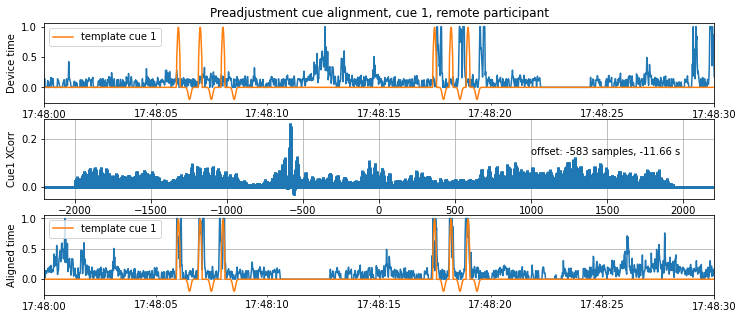

['0', 'spointless', 0.2855936646738785, -585, -11.700000000000001, 4001, 80.02]


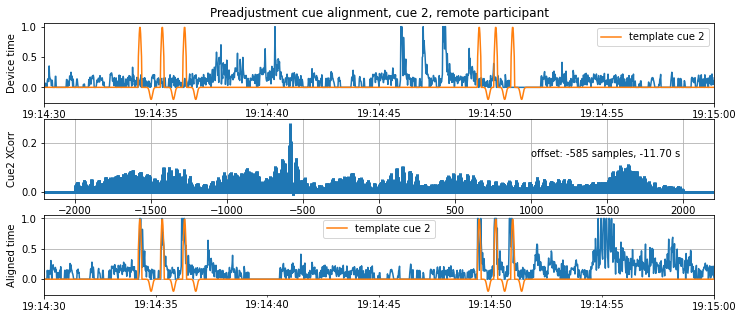

[-583, -585]


In [45]:
shifts = []    

# prep signal for synch 1
signal =sec1_df[dev_n].copy()
signal[signal.isna()] = 0
M = signal.quantile(0.995)
signal = signal/M
signal[signal>1] = 1

if signal.diff().abs().sum()<0.1: # signal is flat
    shifts.append(np.nan)
else: 
    # starting alignment between signal and cue
    fig = plt.figure(figsize=(12,5))
    ax1 = plt.subplot(311)
    signal.plot(ax=ax1)
    cues1.plot.line(y=cue_type,ax=ax1,label='template cue 1')
    plt.xlim([cues1.index[1000],cues1.index[2500]])
    plt.ylabel('Device time')
    plt.title('Preadjustment cue alignment, cue 1, remote participant')
    
    ax2 = plt.subplot(312)
    CCC = ax2.xcorr(cues1[cue_type].iloc[:length1], signal.iloc[:length1], usevlines=True, maxlags=np.min([length1-1,2000]), normed=True, lw=3)
    ax2.grid(True)
    shifts.append(CCC[0][np.argmax(CCC[1])])
    print([str(dev_n),cue_type, np.amax(CCC[1]),CCC[0][np.argmax(CCC[1])], (sampleshift_s*CCC[0][np.argmax(CCC[1])]), len(CCC[0]),len(CCC[0])*sampleshift_s]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
    plt.ylabel('Cue1 XCorr')
    signal.index = signal.index + pd.Timedelta(sampleshift_s*CCC[0][np.argmax(CCC[1])],'S')
    plt.text(1000,np.amax(CCC[1])/2,'offset: %d samples, %.2f s' % (CCC[0][np.argmax(CCC[1])],(sampleshift_s*CCC[0][np.argmax(CCC[1])])))
    ax1 = plt.subplot(313)
    signal.plot(ax=ax1)
    cues1.plot.line(y=cue_type,ax=ax1,label='template cue 1')
    plt.xlim([cues1.index[1000],cues1.index[2500]])
    ax1.grid(True)
    plt.ylabel('Aligned time')
    plt.savefig('Sample_cue1_alignment_remote.png',dpi=300)
    plt.show()
    #sigs[c] = signal
    CCC1 = CCC
# prep signal for synch 1
signal =sec2_df[dev_n].copy()
signal[signal.isna()] = 0
M = signal.quantile(0.995)
signal = signal/M
signal[signal>1] = 1

if signal.diff().abs().sum()<0.1: # signal is flat
    shifts.append(np.nan)
else: 
    # starting alignment between signal and cue
    fig = plt.figure(figsize=(12,5))
    ax1 = plt.subplot(311)
    signal.plot(ax=ax1)
    cues2.plot.line(y=cue_type,ax=ax1,label='template cue 2')
    plt.xlim([cues2.index[1500],cues2.index[3000]])
    plt.title('Preadjustment cue alignment, cue 2, remote participant')
    plt.ylabel('Device time')

    ax2 = plt.subplot(312)
    CCC = ax2.xcorr(cues2[cue_type].iloc[:length2], signal.iloc[:length2], usevlines=True, maxlags=np.min([length2-1,2000]), normed=True, lw=3)
    ax2.grid(True)
    shifts.append(CCC[0][np.argmax(CCC[1])])
    plt.ylabel('Cue2 XCorr')
    #xc = np.correlate(signal.iloc[:length],cues[C2].iloc[:length], "full")
    print([str(dev_n),cue_type, np.amax(CCC[1]),CCC[0][np.argmax(CCC[1])], (sampleshift_s*CCC[0][np.argmax(CCC[1])]), len(CCC[0]),len(CCC[0])*sampleshift_s]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
    plt.text(1000,np.amax(CCC[1])/2,'offset: %d samples, %.2f s' % (CCC[0][np.argmax(CCC[1])],(sampleshift_s*CCC[0][np.argmax(CCC[1])])))
   
    signal.index = signal.index + pd.Timedelta(sampleshift_s*CCC[0][np.argmax(CCC[1])],'S')

    ax1 = plt.subplot(313)
    signal.plot(ax=ax1)
    cues2.plot.line(y=cue_type,ax=ax1,label='template cue 2')
    plt.xlim([cues2.index[1500],cues2.index[3000]])
    ax1.grid(True)
    plt.ylabel('Aligned time')
    plt.savefig('Sample_cue2_alignment_Remote.png',dpi=300)
    plt.show()
    #sigs[c] = signal
    CCC2 = CCC
    
print(shifts)

# Assessing phone clock quality from audience alignment results

## Hall audience first

Was the synch cue paradigm reliable enough to be use for synchronisation? For automated synchronisation?

What did this realignment process do to the recordings in the hall? 

did the local devices need this kind of synchronisation trigger?

Did devices drift in alignment over the 96 mintues between these cues?

In [81]:
Synchs = pd.read_csv('C:/Users/finnu/dev/MusicLabCopenhegan_MotionAlignment/timing/Hall_synchs.csv',index_col = 0)
Synchs.loc[:5]

,s1_corr0,s1_corr_offset,s1_offset,s2_corr0,s2_corr_offset,s2_offset,devID
0,0.264428,0.398857,0.06,0.192332,0.313671,0.10,005093c6-7880-8728-1256-26822f05cfb0_deviceMot...
1,0.191918,0.208169,0.06,0.295367,0.383615,0.10,01393de0-e72e-5e80-f06f-8fdb5d0080cb_deviceMot...
2,0.258848,0.258848,0.00,0.224764,0.330276,0.22,01d00c32-d4dc-8ce6-353c-43143401adf3_deviceMot...
3,0.058390,0.160990,0.94,0.000000,NaN,NaN,03fcbb15-14c6-b806-80b8-e2c161654dd6_deviceMot...
4,0.324572,0.342527,0.08,0.260390,0.260390,0.00,04e20480-91d3-cd85-3470-8656b157978f_deviceMot...
5,0.074430,0.294797,0.62,0.170324,0.324199,0.74,053bd8a0-2ed7-46e9-c088-8eaea2448192_deviceMot...


In [82]:
Synchs = Synchs.drop('devID', axis=1)

In [83]:
print('How many are missing the first synch cue: ' + str((Synchs["s1_offset"]).isna().sum()))
print('How many are missing the second synch cue: ' + str((Synchs["s2_offset"]).isna().sum()))
print('How many have both first and second: ' + str(len(Synchs) - (Synchs["s1_offset"] + Synchs["s2_offset"]).isna().sum()) + ' of ' + str(len(Synchs)))

How many are missing the first synch cue: 9
How many are missing the second synch cue: 12
How many have both first and second: 62 of 80


First is the question of reliability of this synchronisation cue: Could participants performe the tasks and how efficient was it for identifying alignment? 

The tapping cue was constructed carefully to quickly engage metrical entrainment and find the realignent offset despite some amount of variation in how the participants executed in the tapping. A pilot study using a similar cue demonstrated that participants often overtapped: despite instructions and even practice, people often tried to tap to all six beeps instead of just the last three or kept tapping after the beeps stopped. Having them tap at two tempi ensured that we could use the interval between these tap sequences to correctly identify when the beeps happened despite performance variation. This precaution proved necessary as less than half the participants always performed the triple taps as instructed and demonstrated. Close to a quarter made anticipatory taps in at least one cue, and 24 made extra taps. One tap sequence alone would have been easily confused by this behaviour.

But even with the two tempi safeguard, a few were ambiguities or missing. Nearly a quarter had only one descernable synch cue, and in those cases we used it alone to aligne the whole concert. Three recordings had to be discarded because there were none. 

The tapping cue allowed measurements from participants phones to be brought into some degree of alignment, but the process of automatically detecting participants sync taps could be improved. The template came out of several iterations of trying to speed up automation but supervision was necessary and manual corrections were imposed for at least one cue on a substantial number of devices, in person and remote. (10 remote participants' cues required manual correction, 18 in person participants).

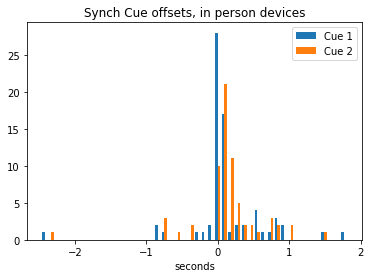

,Means,Medians,Means (abs),Medians (abs),Stds,Mins,Maxs
s1_offset,0.149296,0.06,0.303099,0.10,0.455301,-2.44,1.84
s2_offset,0.189118,0.16,0.362059,0.19,0.449027,-2.34,2.18


In [62]:
align_stats = pd.DataFrame()
align_stats['Means'] = Synchs.mean()
align_stats['Medians'] = Synchs.median()
align_stats['Means (abs)'] = Synchs.abs().mean()
align_stats['Medians (abs)'] = Synchs.abs().median()
align_stats['Stds'] = Synchs.abs().std()
align_stats['Mins'] = Synchs.min()
align_stats['Maxs'] = Synchs.max()

fig, ax = plt.subplots()
A = Synchs['s1_offset'].values
a_heights, a_bins = np.histogram(A[~np.isnan(A)],bins = 46)
A = Synchs['s2_offset'].values
b_heights, b_bins = np.histogram(A[~np.isnan(A)], bins=a_bins)

width = (a_bins[1] - a_bins[0])/2.5

ax.bar(a_bins[:-1], a_heights, width=width,label='Cue 1')
ax.bar(b_bins[:-1]+width, b_heights, width=width,label='Cue 2')
plt.legend()
plt.xlabel('seconds')
plt.title('Synch Cue offsets, in person devices')
plt.savefig('Offsets_distributions_inPerson.png',dpi=300)
plt.show()

align_stats.loc[['s1_offset','s2_offset'],:]

In [88]:
all_offs = Synchs['s1_offset'].abs().values + Synchs['s2_offset'].abs().values
np.nanstd(all_offs)

0.9096362951125334

Was this alignment effort necessary for devices in the hall? 

For the majority of in person participants, their mobile phone clocks were fairly close to concert time. The median absolute offset was 100 ms for the first cue, close our estimated tapping accuracy, and 190 ms for the second cue. However, there were many devices with much larger offsets, up to deviations of over a seconds in both directions. For a minority of devices in the room, the tapping cue, for all its limitations, allows us to substantially improve alignment of the device signals with the music and each other. 

The mean absolute difference from first to second cue: 0.14612903225806448
The median difference from first to second cue: 0.08000000000000002
The median absolute difference from first to second cue: 0.10000000000000005
The std in difference from first to second cue: 0.2049418537185743
The max absolute difference from first to second cue: 0.9
The max difference from first to second cue: 0.48000000000000004
The min difference from first to second cue: -0.9


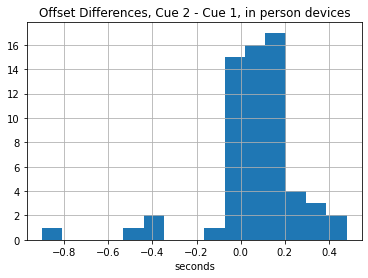

In [91]:
print('The mean absolute difference from first to second cue: ' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).abs().mean()))
print('The median difference from first to second cue: ' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).median()))
print('The median absolute difference from first to second cue: ' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).abs().median()))
print('The std in difference from first to second cue: ' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).std()))
print('The max absolute difference from first to second cue: ' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).abs().max()))
print('The max difference from first to second cue: ' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).max()))
print('The min difference from first to second cue: ' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).min()))

shift_off = Synchs["s2_offset"]-Synchs["s1_offset"]
shift_off.hist(bins = 15)
plt.xlabel('seconds')
plt.title('Offset Differences, Cue 2 - Cue 1, in person devices')
plt.savefig('Drift_distribution_inPerson.png',dpi=300)
plt.show()

The shift from first to second cue was on par with our estimated accuracy of alignment based on the human tapping, suggesting a small amount of systematic drift in most cases. We opted to reset the alignment for each half of the concert for each cue rather than model constant drift between the first and second offsets. 

## Remote participants
Now to assess the realignment results for remote participants.

First we must note that there was substantial variation in how much of the concert remote participants reported responses to, with many only successfully recording their movements through the app for one half or less of the show. As such, we often only had one alignment cue for each participant.

In [63]:
Synchs = pd.read_csv('Rem_synchs_aligned.csv')
Synchs.loc[:5]

,devID,s1_corr0,s1_corr_offset,s1_offset,s2_corr0,s2_corr_offset,s2_offset,MeanShift,Manual1,Manual2,Diff
0,06fad321-8a49-062e-1e84-26704be216b8.Full_Conc...,0.014027,0.322128,-11.64,0.018550,0.338507,-11.70,-11.67,0,0,-0.06
1,09d8163d-80e7-fda3-6919-6a3febc78e27.Full_Conc...,0.023133,0.346800,-7.18,NaN,NaN,NaN,-7.18,0,1,NaN
2,10550c8a-ad24-2550-6344-a0f8b85a4739.Full_Conc...,NaN,NaN,NaN,0.001936,0.038506,-33.14,-33.14,1,1,NaN
3,201c5bcf-081c-b8a2-2be3-f62ee4d10c78.Full_Conc...,0.009721,0.207960,-32.74,NaN,NaN,NaN,-32.74,0,0,NaN
4,214d0cc9-4279-d09c-77aa-ada046ae803f.Full_Conc...,0.019590,0.634280,-13.96,NaN,NaN,NaN,-13.96,0,0,NaN
5,2d115485-bff7-ac99-1682-e3cb88d2f4de.Full_Conc...,0.012139,0.498135,-23.20,NaN,NaN,NaN,-23.20,0,0,NaN


In [64]:
Synchs = Synchs.drop('devID', axis=1)

In [65]:
print('How many are missing the first synch cue: ' + str((Synchs["s1_offset"]).isna().sum()))
print('How many are missing the second synch cue: ' + str((Synchs["s2_offset"]).isna().sum()))
print('How many have both first and second: ' + str(len(Synchs) - (Synchs["s1_offset"] + Synchs["s2_offset"]).isna().sum()) + ' of ' + str(len(Synchs)))

How many are missing the first synch cue: 8
How many are missing the second synch cue: 11
How many have both first and second: 14 of 33


Of the remote participants reporting motion data via the Musiclab app, 33 included at least one discernable synchronisation cue. This set gives us insite into the potential for using manual synch cues to bring these remote responses into alignment. 

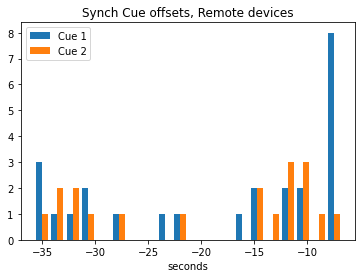

,Means,Medians,Means (abs),Medians (abs),Stds,Mins,Maxs
s1_offset,-17.937600,-13.96,17.937600,13.96,10.886172,-35.30,-6.32
s2_offset,-22.168182,-18.00,22.168182,18.00,12.837142,-53.82,-7.42


In [66]:
align_stats = pd.DataFrame()
align_stats['Means'] = Synchs.mean()
align_stats['Medians'] = Synchs.median()
align_stats['Means (abs)'] = Synchs.abs().mean()
align_stats['Medians (abs)'] = Synchs.abs().median()
align_stats['Stds'] = Synchs.abs().std()
align_stats['Mins'] = Synchs.min()
align_stats['Maxs'] = Synchs.max()

fig, ax = plt.subplots()
A = Synchs['s1_offset'].values
a_heights, a_bins = np.histogram(A[~np.isnan(A)],bins = 20)
A = Synchs['s2_offset'].values
b_heights, b_bins = np.histogram(A[~np.isnan(A)], bins=a_bins)

width = (a_bins[1] - a_bins[0])/2.5

ax.bar(a_bins[:-1], a_heights, width=width,label='Cue 1')
ax.bar(b_bins[:-1]+width, b_heights, width=width,label='Cue 2')
plt.legend()
plt.xlabel('seconds')
plt.title('Synch Cue offsets, Remote devices')
plt.savefig('Offsets_distributions_Remote.png',dpi=300)
plt.show()

align_stats.loc[['s1_offset','s2_offset'],:]

The synchronisation cues served to confirm the delay in the livestream, from the initial offset to the geographic factors extending the time from sounds in the hall to sounds heard on the other side of the world. The minimum offset was a delay of 6.3 seconds, the maximum nearly a minute (54 s). For most analyses associationg human response to music, the comparision is made on the scale of seconds and tenths of second, and these kind of delays render those direct comparisons impossible, without realignment. 

This tapping cue allows us to compensate for these offsets for each participant, bringing the precision of continuous measurements up substantially. But how reliable are these shifts? 

Because the in person devices showed very little drift, we can assume that for remote participants, changes in offset from the first to second cue are more likely caused by shifts in the streamed signal than issues with the device clocks. So what do these shifts look like?

The minimum absolute difference from first to second cue: 0.03999999999999915
The median absolute difference from first to second cue: 0.7099999999999973
The std in difference from first to second cue: 1.6367248186143355
The max absolute difference from first to second cue: 4.299999999999997


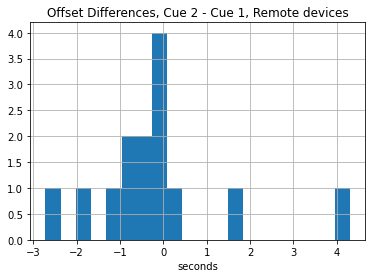

In [67]:
print('The minimum absolute difference from first to second cue: ' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).abs().min()))
print('The median absolute difference from first to second cue: ' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).abs().median()))
print('The std in difference from first to second cue: ' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).std()))
print('The max absolute difference from first to second cue: ' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).abs().max()))
shift_off = Synchs["s2_offset"]-Synchs["s1_offset"]
shift_off.hist(bins = 20)
plt.xlabel('seconds')
plt.title('Offset Differences, Cue 2 - Cue 1, Remote devices')
plt.savefig('Drift_distribution_remote.png',dpi=300)
plt.show()

Less than half the participants following via the live stream recorded discernable tapping cues for both the first and second cue. But even these 14 instances are informative. The median absolute shift between the cues was 0.67 s, a big adjustment, ranging up to 4 whole seconds difference. 

Given the way streams are managed, there can be brief periods of time compression to catch up on a signal, but more often, shifts in streaming offset would be the results of discontinuities. From the participant pausing or reloading the concert livestream by hand to buffering delays produced by inconsistent broadband connections, many events can disrupt the temporal alignment between the live concert and the people watching at home. These midstream shifts are (on average) less than a tenth of the delays compensated caught by a single synchrony cue, but they are still a serious issue for many subsequent analyses.

# What difference does it make?
Looking at alignment quality in several excerpts after tapping alignment. 

1. Gather all the data, remote and local, in concert time
2. Select excerpts for comparison before and after: synch cue, clapping, gasp to sirens?
3. Tight plots 

In [5]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)
# device times 10 Hs
ts_dt = pd.date_range(Start_time,End_time, freq='50ms')
ts_ts = np.arange(Start_time.timestamp(),End_time.timestamp(), 0.05)*1000
# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.05)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')
[dt_ct[0],dt_ct[-1]]

[Timestamp('2021-10-26 17:30:00'), Timestamp('2021-10-26 20:30:00.949999990')]

In [6]:
time_data_folder = 'C:/Users/finnu/dev/MobileMotion_MusicLab/timing/'

concert_times = pd.read_csv(time_data_folder + 'concert_events.csv',",") #SV alignment for beeps
concert_times['S_AudioTime'] = 2*np.round(concert_times["TIME"]/2,2) # reset to 50 hz
concert_times['event'] = concert_times["LABEL"]

concert_times['CTime'] = concert_times['S_AudioTime']-concert_times.loc[38,'S_AudioTime'] # zero on onset of first synch cue
concert_times['StimTime'] = pd.to_timedelta(concert_times['CTime'],unit = 's')
concert_times['ConcertdTime'] = concert_times['StimTime'] + pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
concert_times['time_concert'] = concert_times['CTime']
concert_times=concert_times.set_index('ConcertdTime', drop=True)

In [7]:
# folder of devicewise files for a specific set
folder = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Concated/Hall/alignedDeviceMotion/'
devices = os.listdir(folder)
# prime dataframe and constants
aud_df = pd.DataFrame(index = ts_ts)
dev_n = 0
kept_dev = []
gap_t = 1000 # 1 seconds
file_suffix = 'deviceMotion.csv'

In [11]:
# gather the aligned recordings for the live performance
aud_df = pd.DataFrame(index = ts_ct)
dev_n = 0
kept_dev = []
gap_t = 1000

for devFile in devices[:5]:
    if len(devFile)>10: # clearly an installation ID, not another folder
#         print(devFile)
#         if not devFile.startswith('cc1ce8ab'):
        data = pd.read_csv(folder + '/' + devFile)
        data['datetime_concert'] = pd.to_datetime(data['datetime_concert'])
        datas = gap_nans(data,gap_t)
        resampled = pd.DataFrame(index = ts_ct)
        cols = datas.columns
        for col in cols[1:]:
            f = interpolate.interp1d(datas['time_concert'], datas[col],fill_value='extrapolate')
            resampled[col] = f(ts_ct)

        # extract 1D accelerometer feature for easy comparison
        b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
        if np.nanmedian(b)>0:
            aud_df[dev_n] = b/np.nanmedian(b)
        else:
            aud_df[dev_n] = b/np.nanmean(b)
        dev_n+=1
        kept_dev.append(devFile)

In [12]:
data

,time_concert,datetime_concert,x,y,z,alpha,beta,gamma,timestamp
0,-1095012.0,2021-10-26 17:29:50.988,-9.1225,-2.2945,-3.4563,0.4661,0.3638,0.9669,1635269390908
1,-1094995.0,2021-10-26 17:29:51.005,-9.0003,-2.3055,-3.4292,-1.5404,0.3365,1.6204,1635269390925
2,-1094978.0,2021-10-26 17:29:51.022,-8.9199,-2.1709,-3.3993,-1.2734,0.7815,2.1512,1635269390942
3,-1094961.0,2021-10-26 17:29:51.039,-8.8593,-2.0900,-3.3128,0.2802,-0.0819,2.1361,1635269390959
4,-1094946.0,2021-10-26 17:29:51.054,-8.8707,-2.0527,-3.2245,-0.5430,-0.6905,2.3774,1635269390974
...,...,...,...,...,...,...,...,...,...
481819,8271251.0,2021-10-26 20:05:57.251,2.4832,6.2751,6.5333,1.3585,1.8724,-0.7052,1635278757251
481820,8271268.0,2021-10-26 20:05:57.268,2.1199,6.3913,7.2264,4.2608,-2.7361,1.7382,1635278757268
481821,8271285.0,2021-10-26 20:05:57.285,2.2920,6.4189,7.0258,4.4314,-2.3453,1.6879,1635278757285
481822,8271300.0,2021-10-26 20:05:57.300,2.3816,6.3571,6.8533,3.4503,-1.9691,0.2244,1635278757300


In [72]:
folder = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Concated/Remote/alignedDeviceMotion/'
devices = os.listdir(folder)

for devFile in devices:
    if len(devFile)>10: # clearly an installation ID, not another folder
#         print(devFile)
#         if not devFile.startswith('cc1ce8ab'):
        data = pd.read_csv(folder + '/' + devFile)
        data['datetime_concert'] = pd.to_datetime(data['datetime_concert'])
        datas = gap_nans(data,gap_t)
        resampled = pd.DataFrame(index = ts_ct)
        cols = datas.columns
        for col in cols[1:]:
            f = interpolate.interp1d(datas['time_concert'], datas[col],fill_value='extrapolate')
            resampled[col] = f(ts_ct)

        # extract 1D accelerometer feature for easy comparison
        b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
        if np.nanmedian(b)>0:
            aud_df[dev_n] = b/np.nanmedian(b)
        else:
            aud_df[dev_n] = b/np.nanmean(b)
        dev_n+=1
        kept_dev.append(devFile)

In [73]:
aud_df.index = dt_ct

aud_df

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
2021-10-26 17:30:00.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 17:30:00.050000000,1.210373,6.420046,0.702847,0.655664,3.468137,1.395272,6.745368,0.593249,2.433942,1.161162,...,NaN,NaN,NaN,NaN,NaN,NaN,1.944323,NaN,NaN,5.133444
2021-10-26 17:30:00.100000000,1.098603,3.025195,0.249585,0.420410,4.845336,1.256250,6.473869,0.656793,3.297551,0.837903,...,NaN,NaN,NaN,NaN,NaN,NaN,0.839024,NaN,NaN,0.855553
2021-10-26 17:30:00.150000000,1.420472,5.615968,1.078090,1.060093,4.586760,0.986607,5.138195,0.986899,1.286944,1.800453,...,NaN,NaN,NaN,NaN,NaN,NaN,2.739534,NaN,NaN,4.135931
2021-10-26 17:30:00.200000000,1.085051,8.833666,0.871632,0.730088,11.342569,1.564571,7.712067,0.804307,0.366650,2.119142,...,NaN,NaN,NaN,NaN,NaN,NaN,0.601729,NaN,NaN,4.461964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-26 20:30:00.749999990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 20:30:00.799999990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 20:30:00.849999990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 20:30:00.899999990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Gather the same in device time

In [74]:
# folder of devicewise files for a specific set
folder = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Concated/Hall/alignedDeviceMotion/'
devices = os.listdir(folder)
# prime dataframe and constants
Dev_aud_df = pd.DataFrame(index = ts_ts)
dev_n = 0
kept_dev = []
gap_t = 1000 # 1 seconds
file_suffix = 'deviceMotion.csv'

In [13]:
# gather the original alignments for the hall recordings
Dev_aud_df = pd.DataFrame(index = ts_ts)
dev_n = 0
kept_dev = []
gap_t = 1000

for devFile in devices[:5]:
    if len(devFile)>10: # clearly an installation ID, not another folder
#         print(devFile)
#         if not devFile.startswith('cc1ce8ab'):
        data = pd.read_csv(folder + '/' + devFile)
        data['datetime_concert'] = pd.to_datetime(data['datetime_concert'])
        data['datetime'] = (pd.to_datetime(data['timestamp'],unit='ms'))
        datas = gap_nans(data,gap_t)
        resampled = pd.DataFrame(index = ts_ts)
        cols = datas.columns
        for col in cols[1:]:
            f = interpolate.interp1d(datas['timestamp'], datas[col],fill_value='extrapolate')
            resampled[col] = f(ts_ts)

        # extract 1D accelerometer feature for easy comparison
        b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
        if np.nanmedian(b)>0:
            Dev_aud_df[dev_n] = b/np.nanmedian(b)
        else:
            Dev_aud_df[dev_n] = b/np.nanmean(b)
        dev_n+=1
        kept_dev.append(devFile)

In [14]:
data

,time_concert,datetime_concert,x,y,z,alpha,beta,gamma,timestamp,datetime
0,-1095012.0,2021-10-26 17:29:50.988,-9.1225,-2.2945,-3.4563,0.4661,0.3638,0.9669,1635269390908,2021-10-26 17:29:50.908
1,-1094995.0,2021-10-26 17:29:51.005,-9.0003,-2.3055,-3.4292,-1.5404,0.3365,1.6204,1635269390925,2021-10-26 17:29:50.925
2,-1094978.0,2021-10-26 17:29:51.022,-8.9199,-2.1709,-3.3993,-1.2734,0.7815,2.1512,1635269390942,2021-10-26 17:29:50.942
3,-1094961.0,2021-10-26 17:29:51.039,-8.8593,-2.0900,-3.3128,0.2802,-0.0819,2.1361,1635269390959,2021-10-26 17:29:50.959
4,-1094946.0,2021-10-26 17:29:51.054,-8.8707,-2.0527,-3.2245,-0.5430,-0.6905,2.3774,1635269390974,2021-10-26 17:29:50.974
...,...,...,...,...,...,...,...,...,...,...
481819,8271251.0,2021-10-26 20:05:57.251,2.4832,6.2751,6.5333,1.3585,1.8724,-0.7052,1635278757251,2021-10-26 20:05:57.251
481820,8271268.0,2021-10-26 20:05:57.268,2.1199,6.3913,7.2264,4.2608,-2.7361,1.7382,1635278757268,2021-10-26 20:05:57.268
481821,8271285.0,2021-10-26 20:05:57.285,2.2920,6.4189,7.0258,4.4314,-2.3453,1.6879,1635278757285,2021-10-26 20:05:57.285
481822,8271300.0,2021-10-26 20:05:57.300,2.3816,6.3571,6.8533,3.4503,-1.9691,0.2244,1635278757300,2021-10-26 20:05:57.300


In [ ]:
folder = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Concated/Remote/alignedDeviceMotion/'
devices = os.listdir(folder)

for devFile in devices:
    if len(devFile)>10: # clearly an installation ID, not another folder
#         print(devFile)
#         if not devFile.startswith('cc1ce8ab'):
        data = pd.read_csv(folder + '/' + devFile)
        data['datetime_concert'] = pd.to_datetime(data['datetime_concert'])
        data['datetime'] = (pd.to_datetime(data['timestamp'],unit='ms'))
        datas = gap_nans(data,gap_t)
        resampled = pd.DataFrame(index = ts_ts)
        cols = datas.columns
        for col in cols[1:]:
            f = interpolate.interp1d(datas['timestamp'], datas[col],fill_value='extrapolate')
            resampled[col] = f(ts_ts)

        # extract 1D accelerometer feature for easy comparison
        b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
        if np.nanmedian(b)>0:
            Dev_aud_df[dev_n] = b/np.nanmedian(b)
        else:
            Dev_aud_df[dev_n] = b/np.nanmean(b)
        dev_n+=1
        kept_dev.append(devFile)

In [ ]:
Dev_aud_df.index = ts_dt[:-1]
Dev_aud_df

In [ ]:
#kept_dev

In [ ]:
# plot for perspective
fig, ax = plt.subplots(figsize = [12,6])
chart = sns.heatmap(data=aud_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

freq = int(round(len(aud_df)/len(ax.get_xticks())))
ax.set_xticklabels(aud_df.iloc[::freq].index.strftime("%H:%M"))
plt.title('Aligned App motion sensors worn by in audience participants during Copenhagen concert')
plt.savefig('./Plots/CoverageSnapshot_Copenhagen_Hall_Aligned.png',dpi=300)
plt.show()

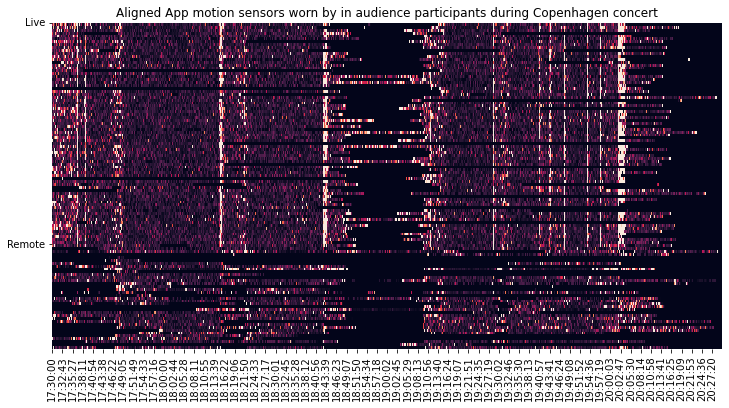

In [79]:
# plot for perspective
fig, ax = plt.subplots(figsize = [12,6])
# chart = sns.heatmap(data=aud_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

# freq = int(round(len(aud_df)/len(ax.get_xticks())))
# ax.set_xticklabels(aud_df.iloc[::freq].index.strftime("%H:%M"))

seg_df = aud_df.copy()
seg_df = seg_df.loc[:,seg_df.sum()>0]
seg_df = seg_df.fillna(0)
chart = sns.heatmap(data=seg_df.transpose(), ax=ax,vmin=0, vmax=8,cbar=False)

# freq = int(round(len(seg_df)/len(ax2.get_xticks())))
ax.set_xticklabels(seg_df.iloc[ax.get_xticks()].index.strftime("%H:%M:%S"))
ax.set_yticks([0,76])
ax.set_yticklabels(['Live','Remote'])

plt.title('Aligned App motion sensors worn by in audience participants during Copenhagen concert')
plt.savefig('./Plots/CoverageSnapshot_Copenhagen_Hall_Aligned.png',dpi=300)
plt.show()

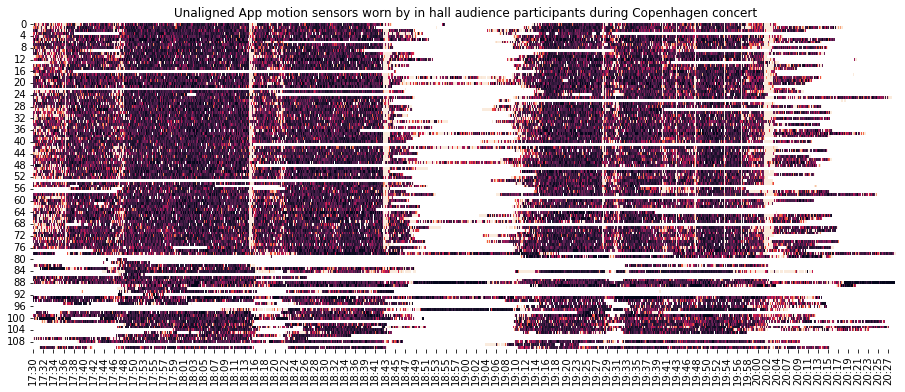

In [30]:
# plot for perspective
fig, ax = plt.subplots(figsize = [15.5,6])
chart = sns.heatmap(data=Dev_aud_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

freq = int(round(len(Dev_aud_df)/len(ax.get_xticks())))
ax.set_xticklabels(Dev_aud_df.iloc[::freq].index.strftime("%H:%M"))
plt.title('Unaligned App motion sensors worn by in hall audience participants during Copenhagen concert')
#plt.savefig('./Plots/CoverageSnapshot_Copenhagen_Hall_raw.png')
plt.show()

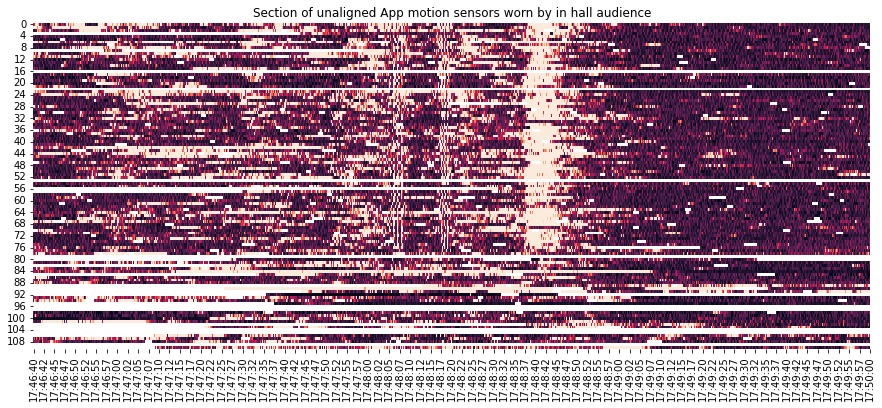

In [35]:
# TODO Make plot that zooms in so we can see the alignment quality
seg_df = Dev_aud_df.loc[ts_dt[10000]:ts_dt[12000]]
fig, ax = plt.subplots(figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

freq = int(round(len(seg_df)/len(ax.get_xticks())))
ax.set_xticklabels(seg_df.iloc[::freq].index.strftime("%H:%M:%S"))
plt.title('Section of unaligned App motion sensors worn by in hall audience')
#plt.savefig('./Plots/Coverage20MinSnapshot_Copenhagen_Hall_raw.png')
plt.show()

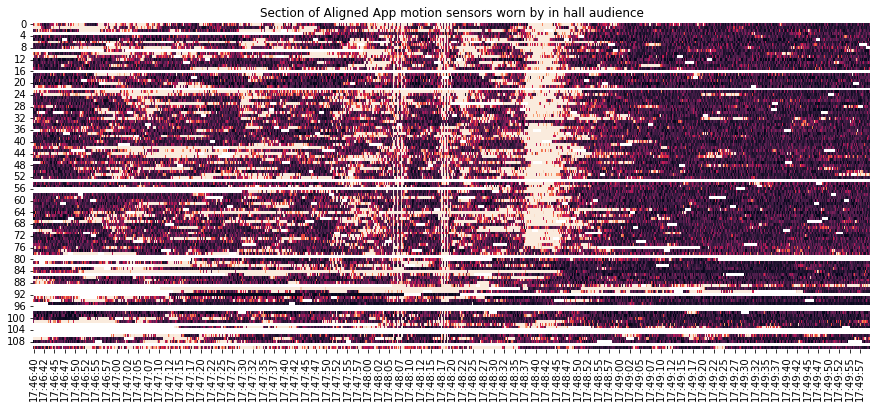

In [36]:
# TODO Make plot that zooms in so we can see the alignment quality
seg_df = aud_df.loc[ts_dt[10000]:ts_dt[12000]]
fig, ax = plt.subplots(figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

freq = int(round(len(seg_df)/len(ax.get_xticks())))
ax.set_xticklabels(seg_df.iloc[::freq].index.strftime("%H:%M:%S"))
plt.title('Section of Aligned App motion sensors worn by in hall audience')
#plt.savefig('./Plots/Coverage20MinSnapshot_Copenhagen_Hall_raw.png')
plt.show()

[Timestamp('2021-10-26 17:48:00'), Timestamp('2021-10-26 17:48:45')]


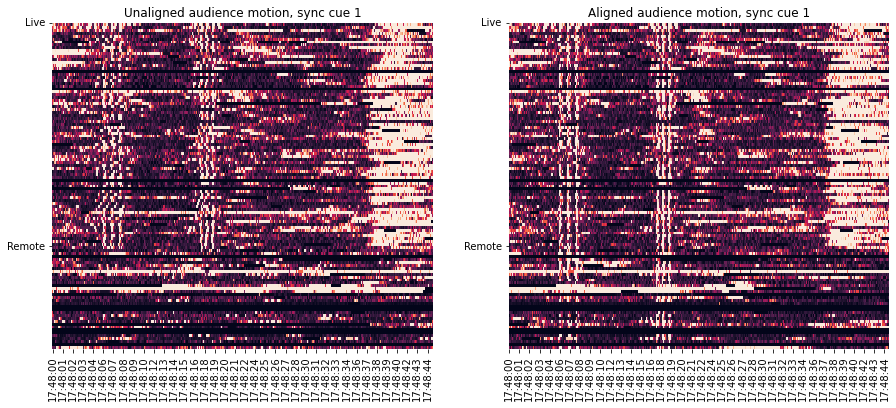

In [246]:
# TODO Make plot that zooms in so we can see the alignment quality
seg_start = pd.to_datetime('2021-10-26 17:48:00+0000').replace(tzinfo=None)
seg_end = pd.to_datetime('2021-10-26 17:48:45+0000').replace(tzinfo=None)

print([seg_start,seg_end])
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = [15,6])

seg_df = Dev_aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
seg_df = seg_df.fillna(0)

chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=8,cbar=False)
ax1.set_xticklabels(seg_df.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))
ax1.set_title('Unaligned audience motion, sync cue 1')
ax1.set_yticks([0,76])
ax1.set_yticklabels(['Live','Remote'])

seg_df = aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
seg_df = seg_df.fillna(0)
chart = sns.heatmap(data=seg_df.transpose(), ax=ax2,vmin=0, vmax=8,cbar=False)

freq = int(round(len(seg_df)/len(ax2.get_xticks())))
ax2.set_xticklabels(seg_df.iloc[ax2.get_xticks()].index.strftime("%H:%M:%S"))
ax2.set_title('Aligned audience motion, sync cue 1')
ax2.set_yticks([0,76])
ax2.set_yticklabels(['Live','Remote'])
plt.savefig('./Plots/Realigned_All_sync1.png',dpi = 300)
plt.show()

[Timestamp('2021-10-26 18:36:50'), Timestamp('2021-10-26 18:37:35')]


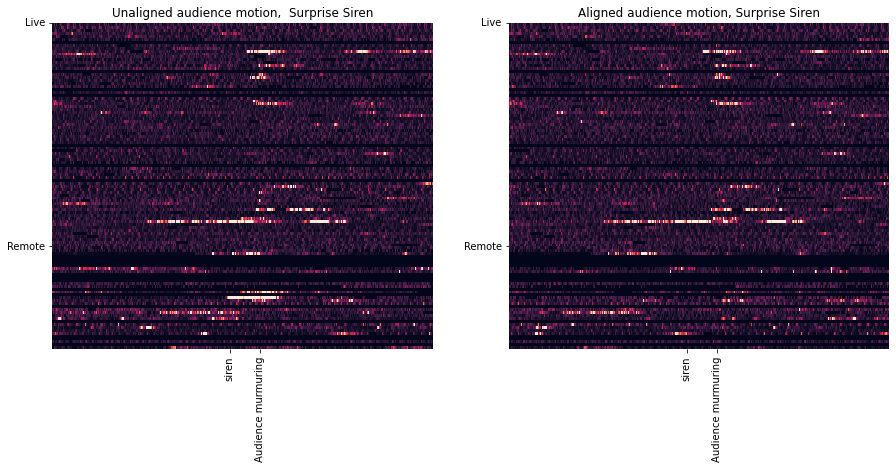

In [247]:
# TODO Make plot that zooms in so we can see the alignment quality
seg_start = pd.to_datetime('2021-10-26 18:36:50+0000').replace(tzinfo=None)
seg_end = pd.to_datetime('2021-10-26 18:37:35+0000').replace(tzinfo=None)

print([seg_start,seg_end])
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = [15,6])

seg_df = Dev_aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
seg_df = seg_df.fillna(0)
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=8,cbar=False)
# ax1.set_xticklabels(seg_df.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))
ax1.set_title('Unaligned audience motion,  Surprise Siren')

seg_ticks = pd.DataFrame(index = seg_df.iloc[ax1.get_xticks()].index)
seg_ticks['tick_values'] = ax1.get_xticks()
seg_x = pd.concat([seg_ticks,concert_times.loc[seg_ticks.index[0]:seg_ticks.index[-1],'LABEL']]).sort_index()
seg_x['tick_values'] = seg_x['tick_values'].interpolate(method='linear')
seg_labels = seg_x.loc[~seg_x[0].isna()]
ax1.set_xticks(seg_labels['tick_values'])
ax1.set_yticks([0,76])
ax1.set_yticklabels(['Live','Remote'])
ax1.set_xticklabels(seg_labels[0])

seg_df = aud_df.loc[seg_start:seg_end]
seg_df = seg_df.fillna(0)
chart = sns.heatmap(data=seg_df.transpose(), ax=ax2,vmin=0, vmax=8,cbar=False)
ax2.set_xticks(seg_labels['tick_values'])
ax2.set_yticks([0,76])
ax2.set_yticklabels(['Live','Remote'])
ax2.set_xticklabels(seg_labels[0])
ax2.set_title('Aligned audience motion, Surprise Siren')
plt.savefig('./Plots/Realigned_All_Siren.png',dpi = 300)
plt.show()

[Timestamp('2021-10-26 20:01:50'), Timestamp('2021-10-26 20:02:35')]


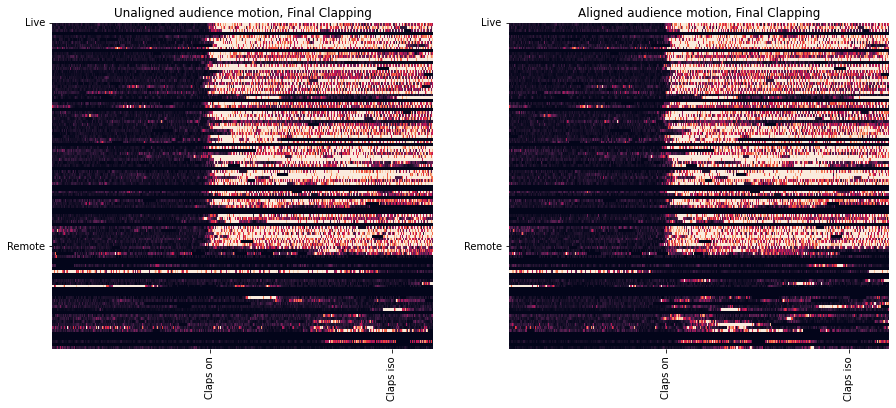

In [248]:
# TODO Make plot that zooms in so we can see the alignment quality
seg_start = pd.to_datetime('2021-10-26 20:01:50+0000').replace(tzinfo=None)
seg_end = pd.to_datetime('2021-10-26 20:02:35+0000').replace(tzinfo=None)
print([seg_start,seg_end])
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = [15,6])

seg_df = Dev_aud_df.loc[seg_start:seg_end]
seg_df = seg_df.fillna(0)
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=20,cbar=False)
ax1.set_title('Unaligned audience motion, Final Clapping')

seg_ticks = pd.DataFrame(index = seg_df.iloc[ax1.get_xticks()].index)
seg_ticks['tick_values'] = ax1.get_xticks()
seg_x = pd.concat([seg_ticks,concert_times.loc[seg_ticks.index[0]:seg_ticks.index[-1],'LABEL']]).sort_index()
seg_x['tick_values'] = seg_x['tick_values'].interpolate(method='linear')
seg_labels = seg_x.loc[~seg_x[0].isna()]
ax1.set_xticks(seg_labels['tick_values'])
ax1.set_xticklabels(seg_labels[0])
ax1.set_yticks([0,76])
ax1.set_yticklabels(['Live','Remote'])
#ax1.grid(linewidth=2,color = 'k')

seg_df = aud_df.loc[seg_start:seg_end]
seg_df = seg_df.fillna(0)
chart = sns.heatmap(data=seg_df.transpose(), ax=ax2,vmin=0, vmax=20,cbar=False)
ax2.set_xticks(seg_labels['tick_values'])
ax2.set_xticklabels(seg_labels[0])
ax2.set_yticks([0,76])
ax2.set_yticklabels(['Live','Remote'])
ax2.set_title('Aligned audience motion, Final Clapping')
plt.savefig('./Plots/Realigned_All_AupplauseF.png',dpi = 300)
plt.show()

[Timestamp('2021-10-26 19:35:50'), Timestamp('2021-10-26 19:37:50')]


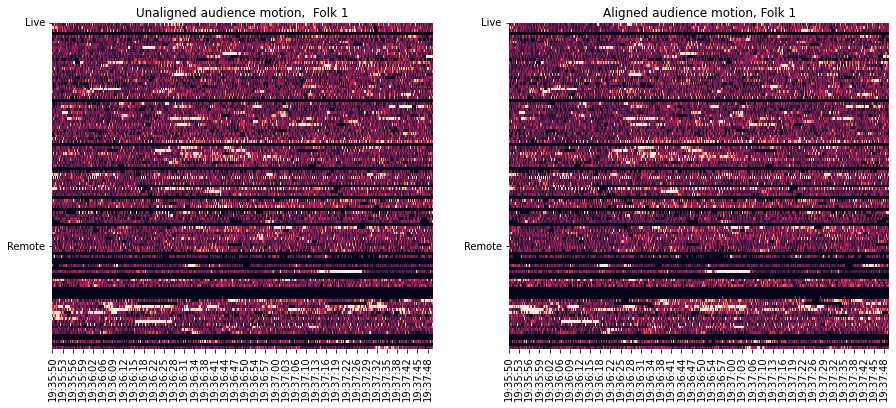

In [249]:
# TODO Make plot that zooms in so we can see the alignment quality
seg_start = pd.to_datetime('2021-10-26 19:35:50+0000').replace(tzinfo=None)
seg_end = pd.to_datetime('2021-10-26 19:37:50+0000').replace(tzinfo=None)
print([seg_start,seg_end])
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = [15,6])

seg_df = Dev_aud_df.loc[seg_start:seg_end]
seg_df = seg_df.fillna(0)
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=3,cbar=False)
ax1.set_title('Unaligned audience motion,  Folk 1')
ax1.set_xticklabels(seg_df.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))
ax1.set_yticks([0,76])
ax1.set_yticklabels(['Live','Remote'])

seg_df = aud_df.loc[seg_start:seg_end]
seg_df = seg_df.fillna(0)
chart = sns.heatmap(data=seg_df.transpose(), ax=ax2,vmin=0, vmax=3,cbar=False)

ax2.set_xticklabels(seg_df.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))
ax2.set_yticks([0,76])
ax2.set_yticklabels(['Live','Remote'])

ax2.set_title('Aligned audience motion, Folk 1')
plt.savefig('./Plots/Realigned_All_Folk1.png',dpi = 300)
plt.show()

In [251]:
seg_end

Timestamp('2021-10-26 19:59:20')